<a href="https://colab.research.google.com/github/shu0518/hw3_m11423036/blob/main/DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###匯入套件

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools

from sklearn.cluster import DBSCAN # <--- DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment # 用於標籤匹配

###定義績效評估函式

In [2]:
# 定義績效評估函式 (SSE, Entropy, Accuracy)

def calculate_sse(X, labels, n_clusters):
    """手動計算 SSE (忽略雜訊 -1)"""
    sse = 0.0
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            centroid = cluster_points.mean(axis=0)
            sse += ((cluster_points - centroid) ** 2).sum()
    return sse

def calculate_entropy(labels_true, labels_pred):
    """計算 Entropy"""
    cm = confusion_matrix(labels_true, labels_pred)
    n_samples = np.sum(cm)
    entropy = 0.0
    for i in range(cm.shape[1]):
        cluster_total = np.sum(cm[:, i])
        if cluster_total > 0:
            p_j = cm[:, i] / cluster_total
            p_j = p_j[p_j > 0]
            e_j = -np.sum(p_j * np.log2(p_j))
            entropy += (cluster_total / n_samples) * e_j
    return entropy

def calculate_accuracy(labels_true, labels_pred):
    """計算準確度 (Accuracy)，含最佳標籤匹配"""
    cm = confusion_matrix(labels_true, labels_pred)
    row_ind, col_ind = linear_sum_assignment(cm.max() - cm)
    accuracy = cm[row_ind, col_ind].sum() / cm.sum()
    return accuracy

def align_labels(labels_true, labels_pred):
    """標籤對齊函式 (忽略雜訊)"""
    mapping = {-1: -1}
    valid_pred_labels = sorted(list(set(labels_pred) - {-1}))
    true_labels = sorted(list(set(labels_true)))

    if not valid_pred_labels:
        return labels_pred

    cost_matrix = np.zeros((len(true_labels), len(valid_pred_labels)))
    for c_idx, pred_l in enumerate(valid_pred_labels):
        for r_idx, true_l in enumerate(true_labels):
            intersection = np.sum((labels_pred == pred_l) & (labels_true == true_l))
            cost_matrix[r_idx, c_idx] = intersection

    row_ind, col_ind = linear_sum_assignment(np.max(cost_matrix) - cost_matrix)

    for r, c in zip(row_ind, col_ind):
        true_l = true_labels[r]
        pred_l = valid_pred_labels[c]
        mapping[pred_l] = true_l

    new_labels = np.array([mapping.get(x, x) for x in labels_pred])
    return new_labels

###資料前處理

In [3]:
# 資料前處理

# 1. 讀取資料
banana_df = pd.read_csv('https://raw.githubusercontent.com/shu0518/hw3_m11423036/refs/heads/main/banana.csv')
sizes3_df = pd.read_csv('https://raw.githubusercontent.com/shu0518/hw3_m11423036/refs/heads/main/sizes3.csv')

# 2. 切分特徵 (X) 與標籤 (y)
X_banana = banana_df[['x', 'y']].values
y_banana = banana_df['class'].values

X_sizes3 = sizes3_df[['x', 'y']].values
y_sizes3 = sizes3_df['class'].values

# 3. 資料標準化
scaler_banana = StandardScaler()
X_banana_std = scaler_banana.fit_transform(X_banana)

scaler_sizes3 = StandardScaler()
X_sizes3_std = scaler_sizes3.fit_transform(X_sizes3)

print("資料載入完成！")
print("-" * 30)
print(f"Banana 資料筆數: {len(banana_df)}")
print("Banana 類別分佈:")
print(banana_df['class'].value_counts().sort_index().to_string())
print("-" * 30)
print(f"Sizes3 資料筆數: {len(sizes3_df)}")
print("Sizes3 類別分佈:")
print(sizes3_df['class'].value_counts().sort_index().to_string())

資料載入完成！
------------------------------
Banana 資料筆數: 4811
Banana 類別分佈:
class
1    2520
2    2291
------------------------------
Sizes3 資料筆數: 1000
Sizes3 類別分佈:
class
0    667
1    111
2    111
3    111


###DBSCAN 執行與評估 - Banana 資料集


>>> DBSCAN: Banana Dataset
最佳參數組合: eps=0.2, minPts=3
Time: 0.0668s | SSE: 5474.8819 | Accuracy: 1.0000 | Entropy: 0.0000


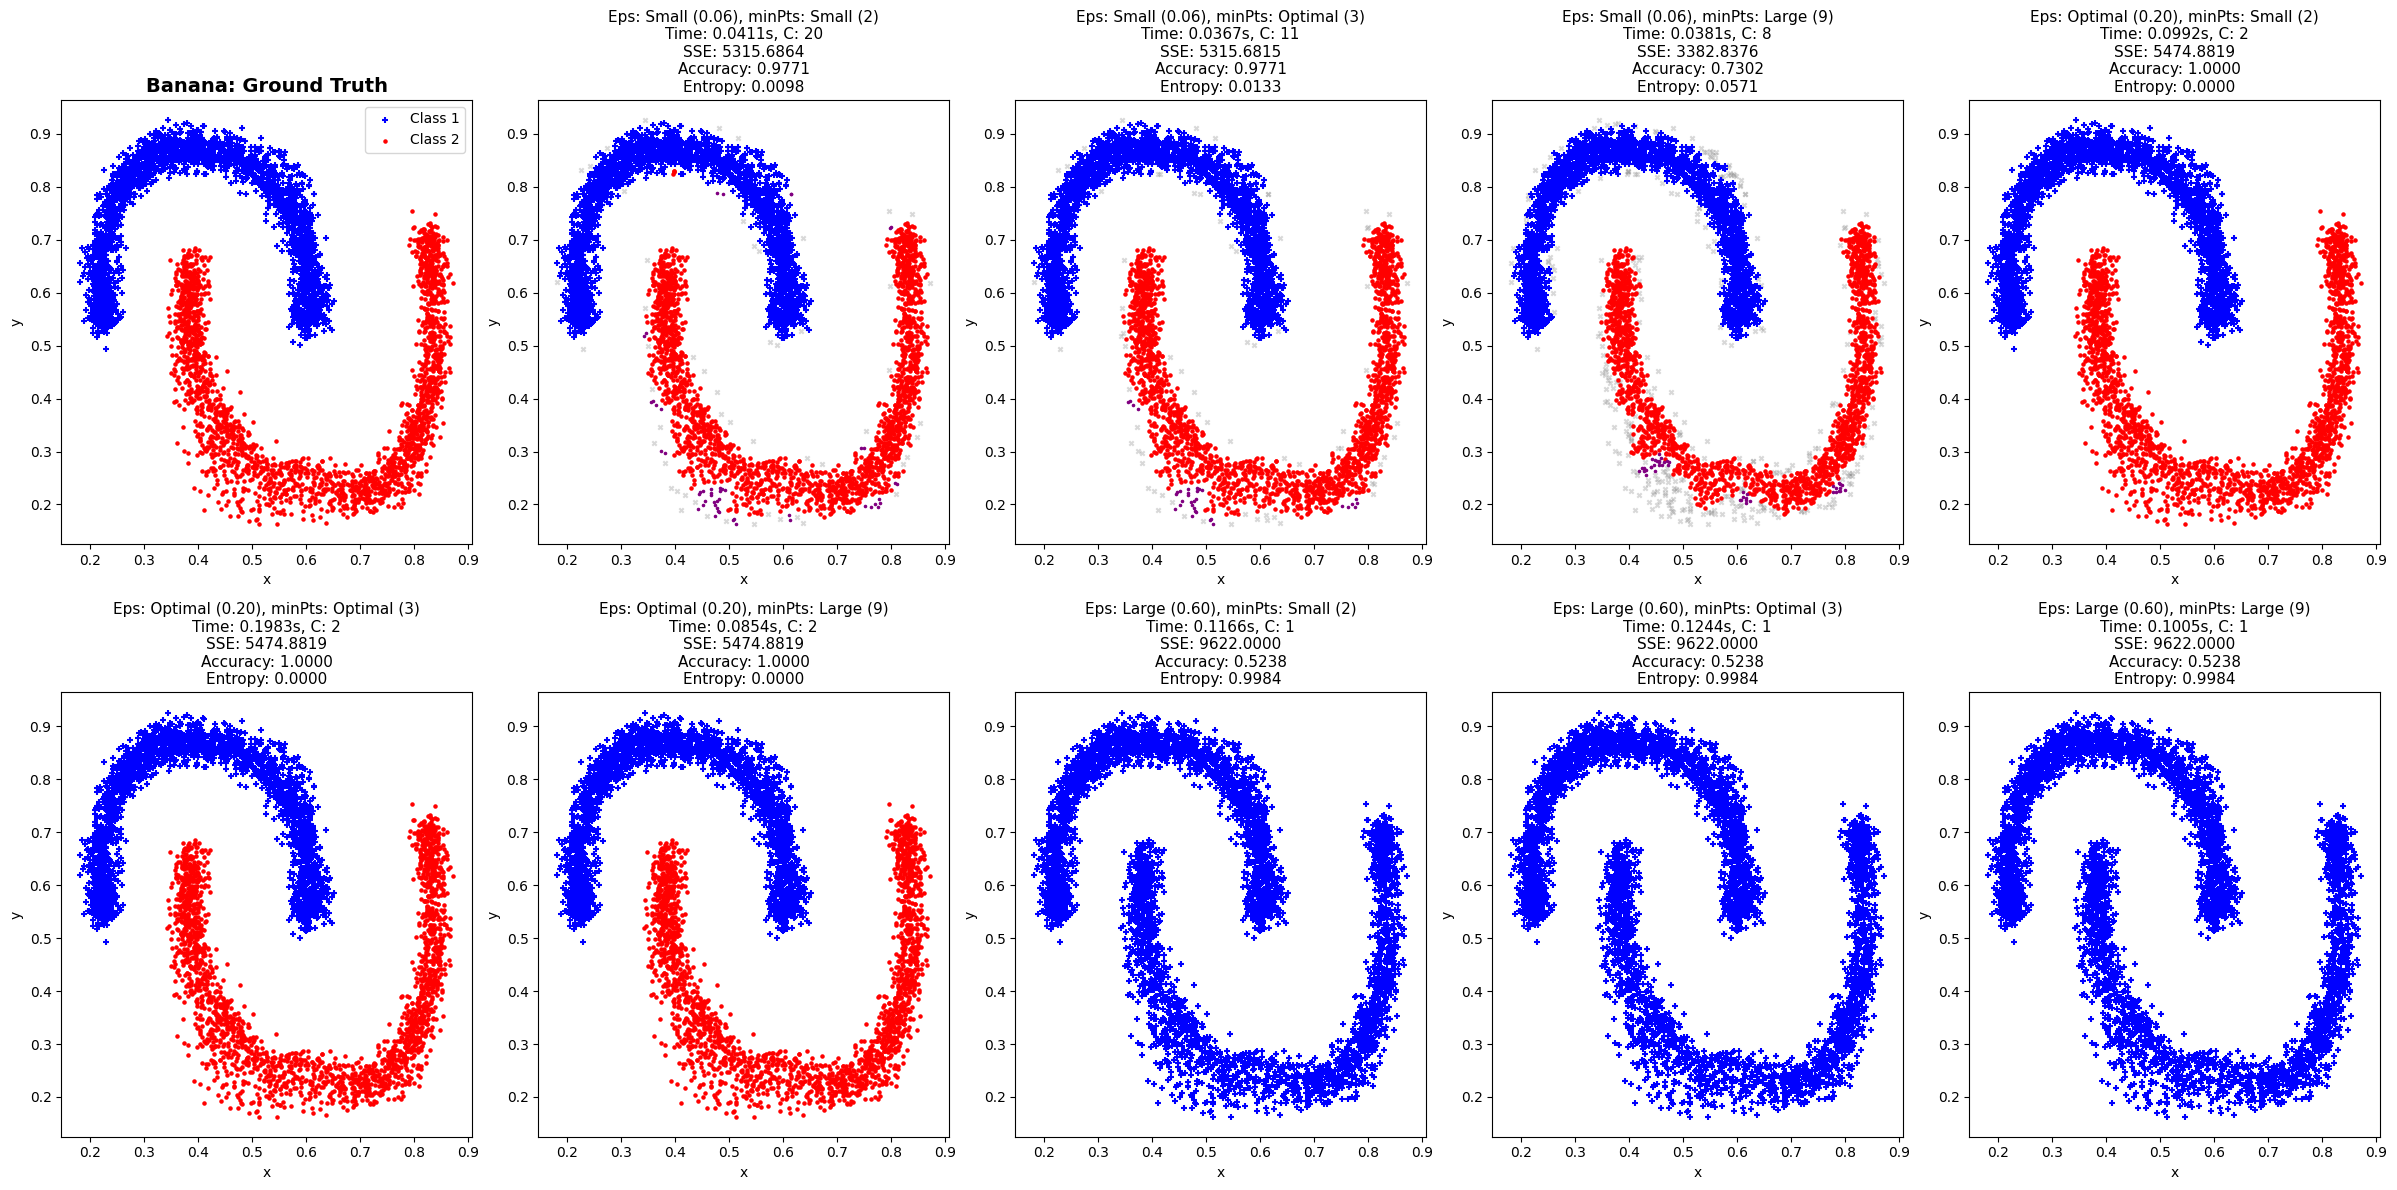

In [4]:
# DBSCAN 執行與評估 - Banana Dataset

print("\n>>> DBSCAN: Banana Dataset")

# --- 1. Grid Search 找最佳參數 ---
eps_candidates = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
min_samples_candidates = [3, 5, 10, 15, 20]

best_score = -1
best_params = None

for eps in eps_candidates:
    for min_samples in min_samples_candidates:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_banana_std)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        acc = calculate_accuracy(y_banana, labels)

        # 目標: 2群, 取最高 Accuracy
        if n_clusters == 2 and acc > best_score:
            best_score = acc
            best_params = (eps, min_samples)

if best_params is None:
    print("未找到最佳參數，使用預設值。")
    best_params = (0.2, 5)

best_eps, best_min = best_params

# 計算最佳參數的詳細指標
start = time.time()
best_labels = DBSCAN(eps=best_eps, min_samples=best_min).fit_predict(X_banana_std)
time_banana = time.time() - start

sse_banana = calculate_sse(X_banana_std, best_labels, n_clusters=2)
acc_banana = calculate_accuracy(y_banana, best_labels)
ent_banana = calculate_entropy(y_banana, best_labels)

print(f"最佳參數組合: eps={best_eps}, minPts={best_min}")
print(f"Time: {time_banana:.4f}s | SSE: {sse_banana:.4f} | Accuracy: {acc_banana:.4f} | Entropy: {ent_banana:.4f}")

# --- 2. 定義 3x3 組合 ---
eps_small = max(0.02, best_eps * 0.3)
eps_large = best_eps * 3.0
min_small = max(2, int(best_min * 0.4))
min_large = int(best_min * 3)

eps_levels = [eps_small, best_eps, eps_large]
min_levels = [min_small, best_min, min_large]

level_names_eps = ["Small", "Optimal", "Large"]
level_names_min = ["Small", "Optimal", "Large"]

# --- 3. 繪圖 (1 張 Ground Truth + 9 張比較圖) ---
fig, axes = plt.subplots(2, 5, figsize=(24, 12))
axes = axes.flatten()

# [圖 0] Ground Truth
ax_gt = axes[0]
ax_gt.set_title("Banana: Ground Truth", fontweight='bold', fontsize=14)
ax_gt.set_xlabel("x")
ax_gt.set_ylabel("y")

ax_gt.scatter(X_banana[y_banana==1, 0], X_banana[y_banana==1, 1],
              s=20, c='blue', marker='+', label='Class 1')
ax_gt.scatter(X_banana[y_banana==2, 0], X_banana[y_banana==2, 1],
              s=5, c='red', marker='o', label='Class 2', facecolors='none', edgecolors='red')
ax_gt.legend()

# [圖 1-9] 3x3 參數網格
combinations = list(itertools.product(enumerate(eps_levels), enumerate(min_levels)))

for idx, ((e_idx, eps), (m_idx, min_pts)) in enumerate(combinations):
    ax = axes[idx + 1]

    # 執行 DBSCAN 並計時
    t0 = time.time()
    db = DBSCAN(eps=eps, min_samples=min_pts)
    labels = db.fit_predict(X_banana_std)
    dt = time.time() - t0

    # 計算指標
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    acc = calculate_accuracy(y_banana, labels)
    sse = calculate_sse(X_banana_std, labels, n_clusters)
    ent = calculate_entropy(y_banana, labels)

    # 對齊
    aligned_labels = align_labels(y_banana, labels)

    # 設定標題 (多行資訊)
    title_str = (f"Eps: {level_names_eps[e_idx]} ({eps:.2f}), minPts: {level_names_min[m_idx]} ({min_pts})\n"
                 f"Time: {dt:.4f}s, C: {n_clusters}\n"
                 f"SSE: {sse:.4f}\n"
                 f"Accuracy: {acc:.4f}\n"
                 f"Entropy: {ent:.4f}")

    ax.set_title(title_str, fontsize=11)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # 畫雜訊
    noise_mask = (labels == -1)
    if np.any(noise_mask):
        ax.scatter(X_banana[noise_mask, 0], X_banana[noise_mask, 1], s=10, c='gray', marker='x', alpha=0.3)

    # 畫群聚
    valid_mask = ~noise_mask
    unique_aligned = sorted(list(set(aligned_labels[valid_mask])))

    for lbl in unique_aligned:
        mask = valid_mask & (aligned_labels == lbl)

        if lbl == 1:
            c, m, s, edge, face = 'blue', '+', 20, None, None
        elif lbl == 2:
            c, m, s, edge, face = 'red', 'o', 5, 'red', 'none'
        else:
            c, m, s, edge, face = 'purple', '.', 10, None, None

        ax.scatter(X_banana[mask, 0], X_banana[mask, 1],
                   s=s, c=c, marker=m, edgecolors=edge, facecolors=face)

plt.tight_layout()
plt.show()

###DBSCAN 執行與評估 - Sizes3 資料集


>>> DBSCAN: Sizes3 Dataset
最佳參數組合: eps=0.4, minPts=20
Time: 0.0108s | SSE: 363.3436 | Accuracy: 0.9460 | Entropy: 0.1792


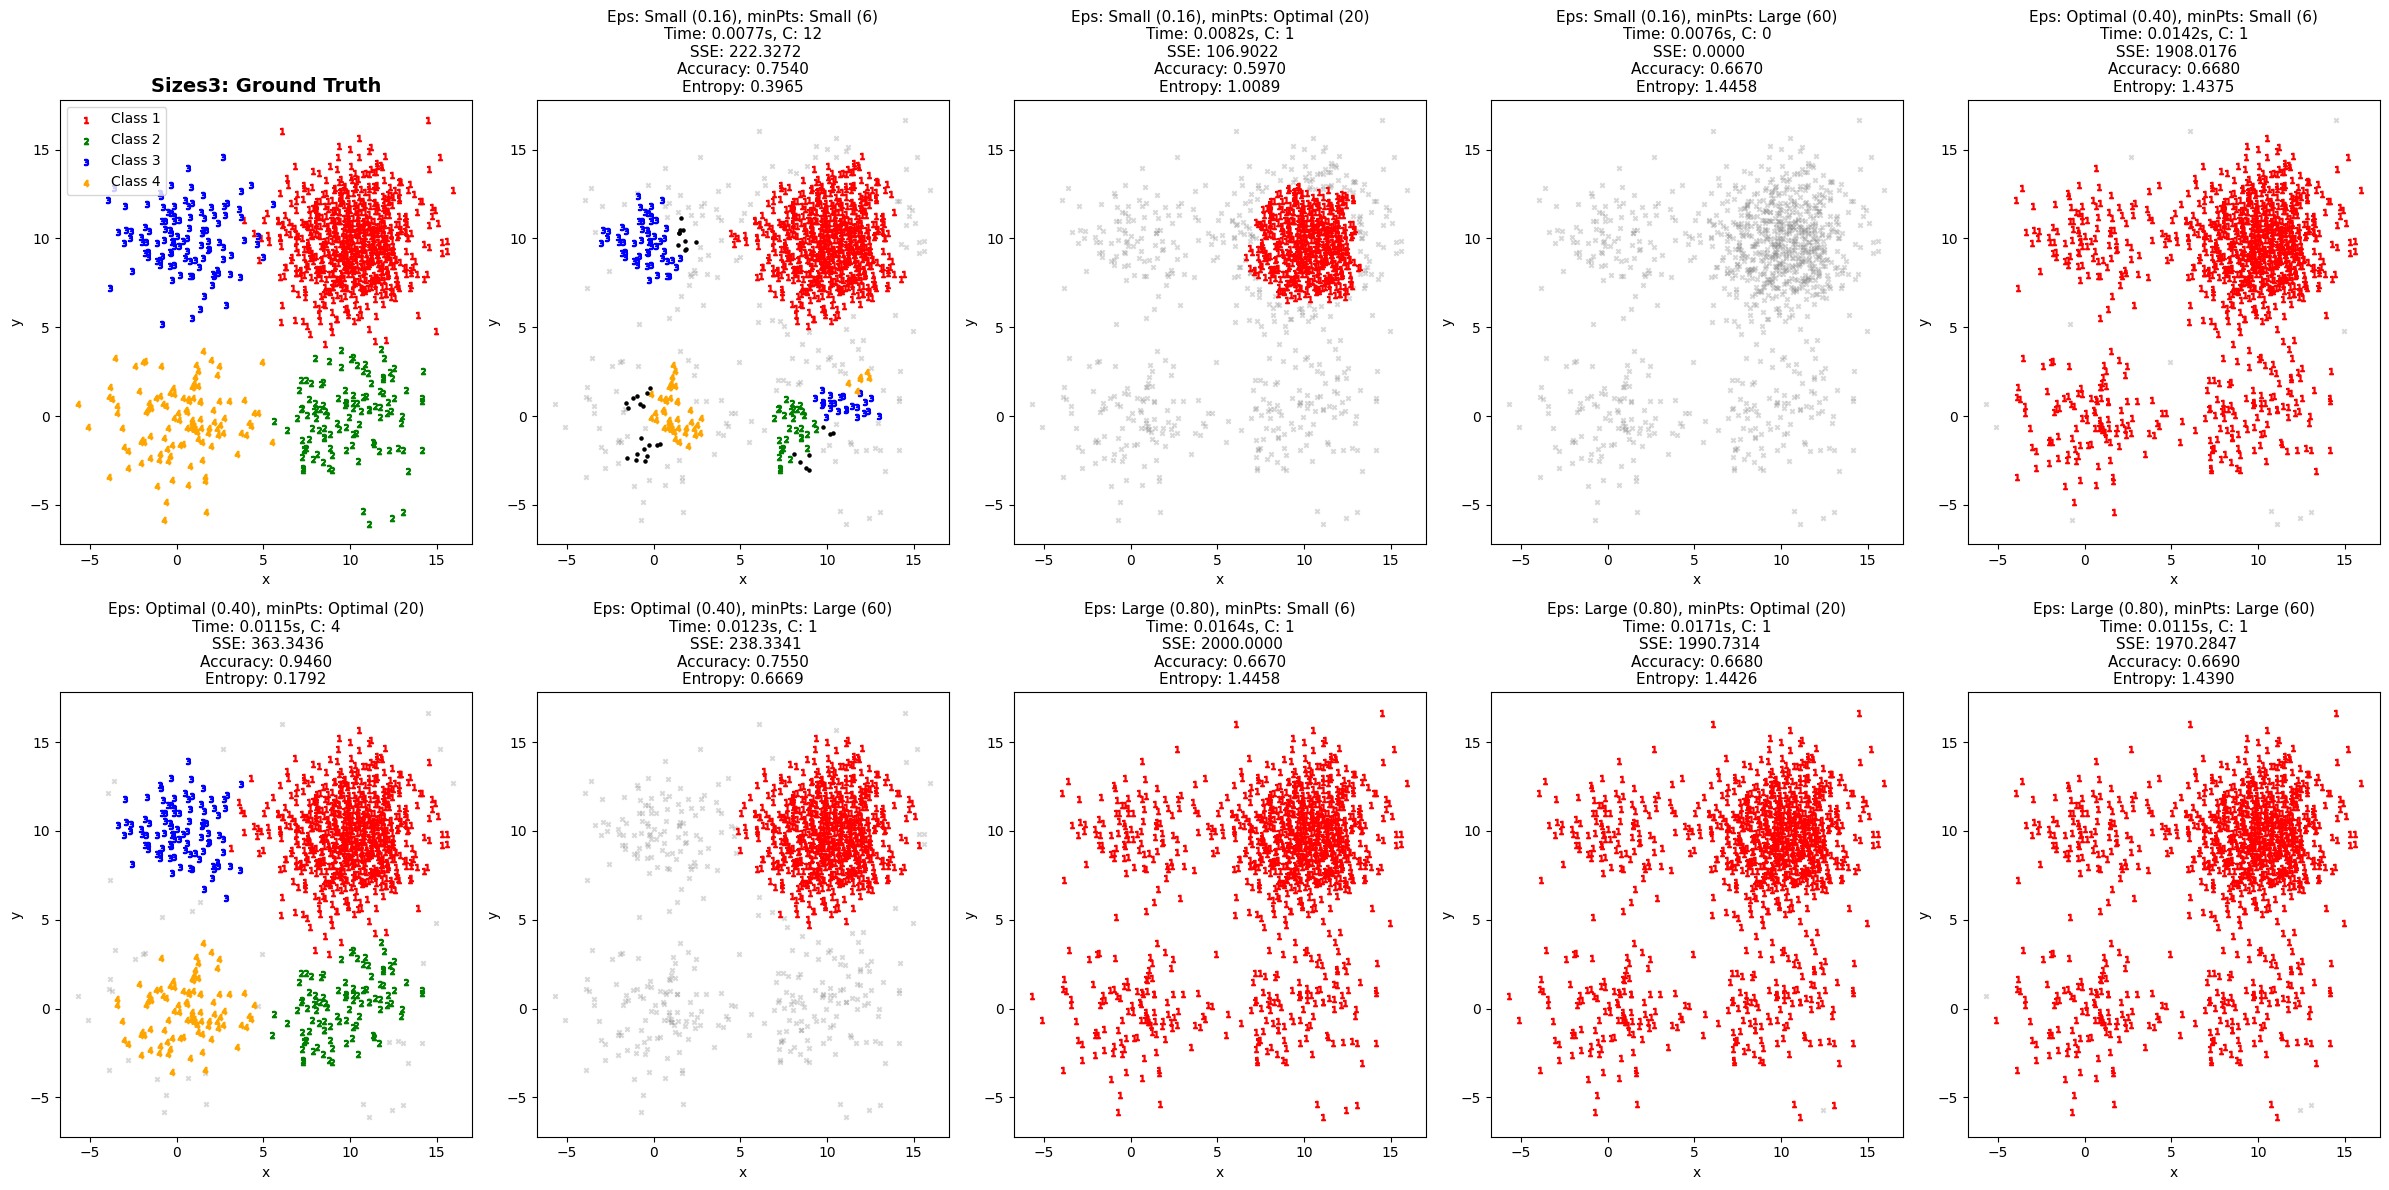

In [5]:
# DBSCAN 執行與評估 - Sizes3 Dataset

print("\n>>> DBSCAN: Sizes3 Dataset")

# --- 1. Grid Search 找最佳參數 ---
eps_candidates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]
min_samples_candidates = [5, 10, 15, 20, 25, 30]

best_score = -1
best_params = None

for eps in eps_candidates:
    for min_samples in min_samples_candidates:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_sizes3_std)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        acc = calculate_accuracy(y_sizes3, labels)

        if n_clusters == 4 and acc > best_score:
            best_score = acc
            best_params = (eps, min_samples)

if best_params is None:
    print("未找到最佳參數，使用預設值。")
    best_params = (0.3, 10)

best_eps, best_min = best_params

# 計算最佳參數的詳細指標
start = time.time()
best_labels = DBSCAN(eps=best_eps, min_samples=best_min).fit_predict(X_sizes3_std)
time_sizes3 = time.time() - start

sse_sizes3 = calculate_sse(X_sizes3_std, best_labels, n_clusters=4)
acc_sizes3 = calculate_accuracy(y_sizes3, best_labels)
ent_sizes3 = calculate_entropy(y_sizes3, best_labels)

print(f"最佳參數組合: eps={best_eps}, minPts={best_min}")
print(f"Time: {time_sizes3:.4f}s | SSE: {sse_sizes3:.4f} | Accuracy: {acc_sizes3:.4f} | Entropy: {ent_sizes3:.4f}")

# --- 2. 定義 3x3 組合 ---
eps_small = max(0.05, best_eps * 0.4)
eps_large = min(1.5, best_eps * 2.0)
min_small = max(3, int(best_min * 0.3))
min_large = int(best_min * 3)

eps_levels = [eps_small, best_eps, eps_large]
min_levels = [min_small, best_min, min_large]

level_names_eps = ["Small", "Optimal", "Large"]
level_names_min = ["Small", "Optimal", "Large"]

# --- 3. 繪圖 (1 張 Ground Truth + 9 張比較圖) ---
fig, axes = plt.subplots(2, 5, figsize=(24, 12))
axes = axes.flatten()

# [圖 0] Ground Truth
ax_gt = axes[0]
ax_gt.set_title("Sizes3: Ground Truth", fontweight='bold', fontsize=14)
ax_gt.set_xlabel("x")
ax_gt.set_ylabel("y")

colors = ['r', 'g', 'b', 'orange']
markers = ['$1$', '$2$', '$3$', '$4$']

for i in range(4):
    ax_gt.scatter(X_sizes3[y_sizes3==i, 0], X_sizes3[y_sizes3==i, 1],
                  s=20, c=colors[i], marker=markers[i], label=f'Class {i+1}')
ax_gt.legend()

# [圖 1-9] 3x3 參數網格
combinations = list(itertools.product(enumerate(eps_levels), enumerate(min_levels)))

for idx, ((e_idx, eps), (m_idx, min_pts)) in enumerate(combinations):
    ax = axes[idx + 1]

    t0 = time.time()
    db = DBSCAN(eps=eps, min_samples=min_pts)
    labels = db.fit_predict(X_sizes3_std)
    dt = time.time() - t0

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    acc = calculate_accuracy(y_sizes3, labels)
    sse = calculate_sse(X_sizes3_std, labels, n_clusters)
    ent = calculate_entropy(y_sizes3, labels)

    aligned_labels = align_labels(y_sizes3, labels)

    title_str = (f"Eps: {level_names_eps[e_idx]} ({eps:.2f}), minPts: {level_names_min[m_idx]} ({min_pts})\n"
                 f"Time: {dt:.4f}s, C: {n_clusters}\n"
                 f" SSE: {sse:.4f}\n"
                 f"Accuracy: {acc:.4f}\n"
                 f"Entropy: {ent:.4f}")

    ax.set_title(title_str, fontsize=11)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # 畫雜訊
    noise_mask = (labels == -1)
    if np.any(noise_mask):
        ax.scatter(X_sizes3[noise_mask, 0], X_sizes3[noise_mask, 1], s=10, c='gray', marker='x', alpha=0.3)

    # 畫群聚
    valid_mask = ~noise_mask
    unique_aligned = sorted(list(set(aligned_labels[valid_mask])))

    for lbl in unique_aligned:
        mask = valid_mask & (aligned_labels == lbl)

        if 0 <= lbl <= 3:
            c = colors[lbl]
            m = markers[lbl]
            s = 20
        else:
            c = 'black'
            m = '.'
            s = 20

        ax.scatter(X_sizes3[mask, 0], X_sizes3[mask, 1], s=s, c=c, marker=m)

plt.tight_layout()
plt.show()